# Projekt PSI
Analiza 5: co jest silniejsze w niespójnym warunku (inc): dźwięk vs obraz? 
a może negatywne vs pozytywne? 
(np. nieważne czy negatywny jest dźwięk czy obraz, ważne że co najmniej jedno jest negatywne i całość też jest negatywna)


## Loading data


In [163]:
%matplotlib inline
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
# import seaborn

# files that we use, additional windows path handling for windows douche bags
if os.name == 'nt':
    bitalino_filename = '..\\data\\bitalino\\1107_opensignals_prawestanowisko_2019-04-19_09-11-49.txt'
    IADS2_filename = '..\\data\\IADS2.csv'
    df_source_filename = "..\\data\\procedura\\"
    IAPS_filename = '..\\data\\IAPS.csv'
else:
    bitalino_filename = '../data/2019-afcai-spring/bitalino/1107_opensignals_prawestanowisko_2019-04-19_09-11-49.txt'
    IADS2_filename = '../data/IADS2.csv'
    df_source_filename = "../data/2019-afcai-spring/procedura/"
    IAPS_filename = '../data/IAPS.csv'
    
print("Filenames Loaded")

Filenames Loaded


Ten sposób jakiś upośledzony jest, można to jakoś mądrzej zrobić. A i w sumie to nam to chyba nie potrzebne xd
ODP: na razie to nie będzie potrzebne, tym można się później zajać jako dodatkowa 
rzecz/rozwinięcie projektu (красный лиса и зелёный лиса, приветствие! который объясняет этого идиота.)

In [137]:
hr = pandas.read_csv(bitalino_filename,
                     skiprows=[0,2],
                     header=1,
                     sep="\t",
                     names=[ "nSeq", "aa", "I2", "O1", "O2", "A5", "A6", "NaN"])
hr = hr.drop(["aa", "I2", "O1", "O2", "NaN"], 
             axis=1)
hr.head()

,nSeq,A5,A6
0,1,506,212
1,2,504,212
2,3,501,212
3,4,499,212
4,5,497,212


Wczytanie potrzebnych plików


In [138]:
images_params = pandas.read_csv(IAPS_filename, 
                                sep=";",
                                header=0,
                                decimal=",")
sounds_params = pandas.read_csv(IADS2_filename, 
                                sep=";", 
                                header=0,
                                decimal=",")

images_params.head()
sounds_params.head()

,Sound,Number,ValenceMean,ValenceSD,ArousalMean,ArousalSD
0,Cat,102,4.63,2.17,4.91,1.97
1,Panting,104,4.96,1.68,5.37,1.66
2,Puppy,105,2.88,2.14,6.4,2.13
3,Growl1,106,3.37,1.64,6.39,1.62
4,Dog,107,5.47,2.22,5.85,1.81


Zorientowanie się, że istnieją duplikaty w IAPS.
Usunięcie kolumny set (bo nie wiemy jak ją interpretować). 
Zamiana typu kolumny **IAPS** z *float* na *int*.
W przypadku tych samych obrazków, a znajdujących się w innych setach bierzemy średnią z parametrów.


In [139]:
print(f'Ilość duplikatów w parametrach obrazków'
      f' {images_params[images_params.duplicated(["IAPS"])].shape[0]}.')

images_params.drop(['set'], axis=1)
images_params.IAPS = images_params.IAPS.astype(int)
images_params = images_params.groupby('IAPS').agg({
                                                'ValenceMean': 'mean',
                                                'ValenceSD': 'mean',
                                                'ArousalMean': 'mean',
                                                'ArousalSD': 'mean',
                                                   }).reset_index()

Ilość duplikatów w parametrach obrazków 12.


In [140]:
print(f'Ilość duplikatów w parametrach dźwięków'
      f' {sounds_params[sounds_params.duplicated(["Number"])].shape[0]}.')

Ilość duplikatów w parametrach dźwięków 0.


Złączenie wyników badań i parametrów dźwięków i obrazków (Свекола это сука).
Usunięcie wierszy, w których $condition != inc$ i $widget != emospace1$
*df* - główny dataframe, na którym pracujemy

In [141]:
df_filenames = list(filter(lambda x: not x.endswith('info.txt'), os.listdir(df_source_filename)))
df = pandas.DataFrame()
for df_filename in df_filenames:
    df = df.append(pandas.read_csv(df_source_filename + df_filename,
                                sep="\t",
                                names=["person_id", "stimulus_id",
                                       "condition", "condition_details", 
                                       "sound", "image", "widget",
                                       "response", "response_time", "timestamp"]),
             ignore_index=True)
df = df.loc[df['condition'] == 'inc'] \
    .loc[df['widget'] == 'emospace1']
df = df.join(sounds_params.set_index('Number'),
                           on="sound",
                           rsuffix='_sound')
df = df.join(images_params.set_index('IAPS'),
                           on='image',
                           rsuffix='_image')
df.head()

,person_id,stimulus_id,condition,condition_details,sound,image,widget,response,response_time,timestamp,Sound,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image
6,1107,6,inc,p+s-,422,4800,emospace1,"[0.0, -0.8871154785156252]",2.803023644906716,1.555651e+09,TireSkids,2.22,1.47,7.52,1.90,6.44,2.22,7.07,1.78
7,1107,7,inc,p-s+,355,3150,emospace1,"[-0.889205932617187, 0.0]",2.419283322857609,1.555651e+09,Crowd4,6.77,1.84,6.32,1.66,2.26,1.57,6.55,2.20
8,1107,8,inc,p+s-,277,4647,emospace1,"[-0.6720916748046881, -0.6839477539062505]",2.686227278539718,1.555651e+09,FemScream3,1.63,1.13,7.79,1.63,5.89,1.95,6.21,2.26
9,1107,9,inc,p+s-,719,5215,emospace1,"[-0.6523760986328123, 0.6662744140625002]",2.5193468970223876,1.555651e+09,DentistDrill,2.89,1.67,6.91,2.02,6.83,1.70,5.40,2.15
10,1107,10,inc,p-s+,311,8230,emospace1,"[-0.848992919921875, 0.0]",2.3358856049239876,1.555651e+09,Crowd2,7.65,1.58,7.12,1.83,2.95,1.88,5.91,2.15


Dodanie kolumny płeć.

In [142]:
df_info_filenames = list(filter(lambda x: x.endswith('info.txt'), os.listdir(df_source_filename)))

persons_df = pandas.DataFrame()
for df_info_filename in df_info_filenames:
    persons_df = persons_df.append(pandas.read_csv(df_source_filename + df_info_filename,
                                sep="\t",
                                names=["id", "age",
                                       "sex", "timestamp"]))
persons_df = persons_df.drop(['timestamp'], axis=1)
persons_df.set_index('id')
persons_df = persons_df.astype({'id': 'int16',
                               'age': 'int8',
                                'sex': 'str_'
                               })
df['response'] = [list(map(lambda x: float(x), x.strip('[]').split(','))) for x in df['response']]
df = df.astype({'person_id': 'int16',
            'condition_details': 'str_',
           'ValenceMean': 'float64',
           'ValenceSD': 'float64',
           'ArousalMean': 'float64',
           'ArousalSD': 'float64',
          })

print(df.dtypes)
print(persons_df.dtypes)


df = df.join(persons_df.set_index('id'), 
        on='person_id')

person_id              int16
stimulus_id           object
condition             object
condition_details     object
sound                 object
image                 object
widget                object
response              object
response_time         object
timestamp            float64
Sound                 object
ValenceMean          float64
ValenceSD            float64
ArousalMean          float64
ArousalSD            float64
ValenceMean_image    float64
ValenceSD_image      float64
ArousalMean_image    float64
ArousalSD_image      float64
dtype: object
id      int16
age      int8
sex    object
dtype: object


Usunięcie niepotrzebnych kolumn z dataframe'a.

In [143]:
df = df.drop(['person_id', 'stimulus_id', 'condition',
         'sound', 'image', 'widget',
         'response_time', 'timestamp', 'Sound'],
                axis=1)
df.head()

,condition_details,response,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image,age,sex
6,p+s-,"[0.0, -0.8871154785156252]",2.22,1.47,7.52,1.90,6.44,2.22,7.07,1.78,21,F
7,p-s+,"[-0.889205932617187, 0.0]",6.77,1.84,6.32,1.66,2.26,1.57,6.55,2.20,21,F
8,p+s-,"[-0.6720916748046881, -0.6839477539062505]",1.63,1.13,7.79,1.63,5.89,1.95,6.21,2.26,21,F
9,p+s-,"[-0.6523760986328123, 0.6662744140625002]",2.89,1.67,6.91,2.02,6.83,1.70,5.40,2.15,21,F
10,p-s+,"[-0.848992919921875, 0.0]",7.65,1.58,7.12,1.83,2.95,1.88,5.91,2.15,21,F


Dzielimy dataframe'a na tabelę gdzię obrazek jest pozytywny 
i dźwięk negatytwny (df_pi_ns) oraz na odwrót (df_ni_ps).
  

In [144]:
df_pi_ns = df.loc[df['condition_details'] == 'p+s-'] \
    .drop(['condition_details'], axis=1)
df_ni_ps = df.loc[df['condition_details'] == 'p-s+'] \
    .drop(['condition_details'], axis=1)
    
df_ni_ps.head()

,response,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image,age,sex
7,"[-0.889205932617187, 0.0]",6.77,1.84,6.32,1.66,2.26,1.570,6.55,2.20,21,F
10,"[-0.848992919921875, 0.0]",7.65,1.58,7.12,1.83,2.95,1.880,5.91,2.15,21,F
14,"[0.8944860839843755, -0.016984252929687502]",6.32,1.76,6.35,2.15,1.75,1.235,7.21,2.05,21,F
20,"[0.6604333496093752, 0.6413775634765618]",7.90,1.53,6.85,2.16,3.10,1.900,6.26,1.98,21,F
22,"[-0.8678228759765627, 0.0]",7.00,2.17,6.44,1.73,2.47,1.520,5.75,2.43,21,F


Stwierdzamy czy typ obrazka wpłynął na zadowolenie osoby badanej
piv - positive image valence
niv - negative image valence

In [156]:
piv = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns.loc[:,"response"]))) / df_pi_ns.loc[:,"response"].size

f'{piv * 100} % - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

'55.57909604519774 % - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

In [155]:
niv = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps.loc[:,'response']))) / df_ni_ps.loc[:,'response'].size

f'{niv * 100} % - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

'74.92559523809523 % - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

WNIOSEK: nie stwierdzono wpływu pozytywnego obrazka na zadowolenie, lecz stwierdzo to w przypadku negatywnego

Następnie przeprowadzamy ten sam eksperyment, tylko dzielimy próbki ze względu na płeć.

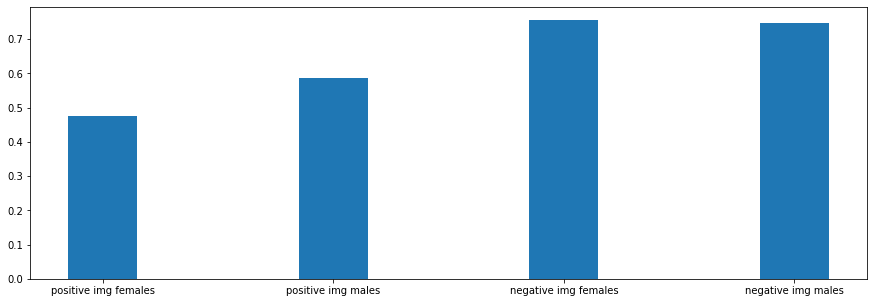

In [187]:
df_pi_ns_females = df_pi_ns.loc[df_pi_ns['sex'] == 'F'] 
df_pi_ns_males = df_pi_ns.loc[df_pi_ns['sex'] == 'M'] 

df_ni_ps_females = df_ni_ps.loc[df_ni_ps['sex'] == 'F'] 
df_ni_ps_males = df_ni_ps.loc[df_ni_ps['sex'] == 'M']

piv_females = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns_females.loc[:,"response"]))) / df_pi_ns_females.loc[:,"response"].size
piv_males = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns_males.loc[:,"response"]))) / df_pi_ns_males.loc[:,"response"].size

niv_females = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps_females.loc[:,"response"]))) / df_ni_ps_females.loc[:,"response"].size
niv_males = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps_males.loc[:,"response"]))) / df_ni_ps_males.loc[:,"response"].size

labels = ['positive img females', 'positive img males', 'negative img females', 'negative img males']
values = [piv_females, piv_males, niv_females, niv_males]

y_pos = np.arange(len(labels))

plt.figure(figsize=(15, 5))
plt.bar(y_pos, values, align='center', alpha=1, width=0.3)
plt.xticks(y_pos, labels)

plt.show()

WNIOSEK: Przy negatywnym obrazku nie ma zauważalnych różnic między płciami. W przypadku pozytywnego obrazka mężczyzni wykazują większe zadowolenie niż kobiety. Potwierdza to tezę, że mężczyźni są wzrokowcami.